### Goal : Plot MAPE*training size
--

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tuxml

In [2]:
features = tuxml.load_dataset()
selection = pd.read_csv("feature_net.csv", index_col = 0, skiprows = 1, names = ['feat'])['feat']
selection[len(selection)] = 'vmlinux'
features = features[selection].replace([2,-1],0)

We first cut the dataset into training-validation parts

In [3]:
n = 65000
sizes = np.array(features[0:n]['vmlinux'])
x_train, x_test, y_train, y_test = train_test_split(features.drop('vmlinux', axis=1)[0:n], sizes, test_size = 0.1)

x_train = np.array(x_train, dtype = np.float32)
x_test =  np.array(x_test, dtype = np.float32)

y_train = np.array(y_train, dtype = np.float32)
y_test = np.array(y_test, dtype = np.float32)

res = []

Then we try to reach the lowest MAPE with a given percentage of the training set. The testing set will always be the same, whatever the training size.

We use three different neural network's architectures, in function of the size of the training set:
- tiny under 1000 configurations
- small between 1000 and 10k conf
- standard for more than 10k config

In [4]:
def compute_tiny(training_x, training_y, testing_x, testing_y, batch_size = 20, nb_epochs = 5, learning_rate = 1000):

    nb_features = training_x.shape[1]
    nb_batch_train = int(len(training_x)/batch_size)
    nb_batch_test = int(len(testing_x)/batch_size)
    
    dataset_train = tf.data.Dataset.from_tensor_slices((training_x, training_y)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()
    
    with tf.device("/gpu:0"):
        
        w_h1 = tf.Variable(tf.glorot_uniform_initializer()((nb_features, 1)))
        
        outputs_tr = tf.reshape(tf.matmul(xtr, w_h1), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])
        
        outputs_te =  tf.reshape(tf.matmul(xte, w_h1), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])
        
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        train_step = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)
        
        init = tf.global_variables_initializer()
        
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(nb_epochs):
            sess.run(iterator_train.initializer)
            for i in range(nb_batch_train):
                val = sess.run(train_step)
        mape_train = 0
        sess.run(iterator_train.initializer)
        for i in range(nb_batch_train):
            mape_train+=sess.run(train_cost)
        print("Training final cost =", mape_train/nb_batch_train)
        mape_test = 0
        sess.run(iterator_test.initializer)
        for i in range(nb_batch_test):
            mape_test+=sess.run(test_cost)
        print("Test final cost =", mape_test/nb_batch_test)
        return (mape_train/nb_batch_train, mape_test/nb_batch_test)

In [5]:
def compute_small(training_x, training_y, testing_x, testing_y, batch_size = 20, nb_epochs = 5, 
                  learning_rate = 10, nb_node_layer1 = 200):
    
    nb_features = training_x.shape[1]
    nb_batch_train = int(len(training_x)/batch_size)
    nb_batch_test = int(len(testing_x)/batch_size)
    
    dataset_train = tf.data.Dataset.from_tensor_slices((training_x, training_y)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()
    
    with tf.device("/gpu:0"):
        w_h1_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_features, nb_node_layer1)), name = "w_h1_tr")
        mat_h1_tr = tf.matmul(xtr, w_h1_tr)
        b_h1_tr = tf.Variable(tf.zeros(nb_node_layer1), name="b_h1_tr")
        out_h1_tr = tf.nn.relu(tf.add(mat_h1_tr, b_h1_tr))
        
        mat_h1_te = tf.matmul(xte, w_h1_tr)
        out_h1_te = tf.nn.relu(tf.add(mat_h1_te, b_h1_tr))
        
        w_h2 = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer1, 1)))
        
        outputs_tr = tf.reshape(tf.matmul(out_h1_tr, w_h2), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])
        
        outputs_te =  tf.reshape(tf.matmul(out_h1_te, w_h2), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])
        
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        train_step = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)
        
        init = tf.global_variables_initializer()
        
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(nb_epochs):
            sess.run(iterator_train.initializer)
            for i in range(nb_batch_train):
                val = sess.run(train_step)
        mape_train = 0
        sess.run(iterator_train.initializer)
        for i in range(nb_batch_train):
            mape_train+=sess.run(train_cost)
        print("Training final cost =", mape_train/nb_batch_train)
        mape_test = 0
        sess.run(iterator_test.initializer)
        for i in range(nb_batch_test):
            mape_test+=sess.run(test_cost)
        print("Test final cost =", mape_test/nb_batch_test)
        return (mape_train/nb_batch_train, mape_test/nb_batch_test)

In [6]:
def compute_standard(training_x, training_y, nb_features = x_train.shape[1], nb_node_layer1 = 200, 
                     nb_node_layer2 = 100, batch_size = 50, nb_epochs = 30):
    
    nb_batch_train = int(len(training_x)/batch_size)
    nb_batch_test = int(len(x_test)/batch_size)

    # slice the datasets => feed_dict was very slow, so I choose an iterator solution
    dataset_train = tf.data.Dataset.from_tensor_slices((training_x, training_y)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()

    with tf.device("/gpu:0"):
        # Layers training
        w_h1_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_features, nb_node_layer1)), name = "w_h1_tr")
        mat_h1_tr = tf.matmul(xtr, w_h1_tr)
        b_h1_tr = tf.Variable(tf.zeros(nb_node_layer1), name="b_h1_tr")
        out_h1_tr = tf.nn.relu(tf.add(mat_h1_tr, b_h1_tr))

        w_h2_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer1, nb_node_layer2)), name = "w_h2_tr")
        mat_h2_tr = tf.matmul(out_h1_tr, w_h2_tr)
        b_h2_tr = tf.Variable(tf.zeros(nb_node_layer2), name="b_h2_tr")
        out_h2_tr = tf.nn.relu(tf.add(mat_h2_tr, b_h2_tr))

        w_final_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer2, 1)), name = "w_final_tr")
        outputs_tr =  tf.reshape(tf.matmul(out_h2_tr, w_final_tr), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])

        # Layers test
        mat_h1_te = tf.matmul(xte, w_h1_tr)
        out_h1_te = tf.nn.relu(tf.add(mat_h1_te, b_h1_tr))

        mat_h2_te = tf.matmul(out_h1_te, w_h2_tr)
        out_h2_te = tf.nn.relu(tf.add(mat_h2_te, b_h2_tr))

        outputs_te =  tf.reshape(tf.matmul(out_h2_te, w_final_tr), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])

        # Cost => MAPE
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        # Convergence function => AdamOptimizer
        train_step = tf.train.AdamOptimizer(learning_rate=1).minimize(train_cost)

        # train step with a lower learning rate => gain few % at the end
        tiny_train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(train_cost)

        # allocate memory for tensors
        init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for j in range(nb_epochs):
            if j < 20:
                sess.run(iterator_train.initializer)
                for i in range(nb_batch_train):
                    val = sess.run(train_step)
                #print("Train epoch n°", j+1, ":",  sess.run(train_cost))
            else:
                sess.run(iterator_train.initializer)
                for i in range(nb_batch_train):
                    val = sess.run(tiny_train_step)
                #print("Train epoch n°", j+1, ":",  sess.run(train_cost))
        sess.run(iterator_train.initializer)
        mape_train = 0
        for i in range(nb_batch_train):
            mape_train+=sess.run(train_cost)
        print("Training final cost =", mape_train/nb_batch_train)
        mape_test = 0
        sess.run(iterator_test.initializer)
        for i in range(nb_batch_test):
            mape_test+=sess.run(test_cost)
        print("Test final cost =", mape_test/nb_batch_test)
        return (mape_train/nb_batch_train, mape_test/nb_batch_test)

For each size, we take the average train/test MAPE of 10 launches

In [7]:
nb_launches = 10

tiny_sizes = [200, 500, 750]

for ts in tiny_sizes:
    mtr_list = []
    mte_list = []
    for i in range(nb_launches):
        training_x, _, training_y, _ = train_test_split(x_train, y_train, 
                                                        train_size = ts/len(x_train), test_size = 1-ts/len(x_train))
        print("Size", len(training_y), ":")
        mtr, mte = compute_tiny(training_x, training_y, x_test, y_test)
        mtr_list.append(mtr)
        mte_list.append(mte)
    res.append((ts, np.mean(mtr_list), np.mean(mte_list)))

small_sizes = [1000, 2000, 5000]

for ts in small_sizes:
    mtr_list = []
    mte_list = []
    for i in range(nb_launches):
        training_x, _, training_y, _ = train_test_split(x_train, y_train, 
                                                        train_size = ts/len(x_train), test_size = 1-ts/len(x_train))
        print("Size", len(training_y), ":")
        mtr, mte = compute_small(training_x, training_y, x_test, y_test)
        mtr_list.append(mtr)
        mte_list.append(mte)
    res.append((ts, np.mean(mtr_list), np.mean(mte_list)))

big_sizes = [10000, 20000, 40000, len(x_train)]

for ts in big_sizes:
    
    mtr_list = []
    mte_list = []
    if ts != len(x_train):
        for i in range(nb_launches):
            training_x, _, training_y, _ = train_test_split(x_train, y_train, 
                                                            train_size = ts/len(x_train), test_size = 1-ts/len(x_train))
            print("Size", len(training_y), ":")
            mtr, mte = compute_standard(training_x, training_y)
            mtr_list.append(mtr)
            mte_list.append(mte)
        res.append((ts, np.mean(mtr_list), np.mean(mte_list)))
    else:
        for i in range(nb_launches):
            print("Size", len(x_train), ":")
            mtr, mte = compute_standard(x_train, y_train)
            mtr_list.append(mtr)
            mte_list.append(mte)
        res.append((ts, np.mean(mtr_list), np.mean(mte_list)))

Size 200 :
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Training final cost = 66.15219841003417
Test final cost = 64.75607252854567
Size 200 :
Training final cost = 67.39597702026367
Test final cost = 65.04344346266527
Size 200 :
Training final cost = 64.814501953125
Test final cost = 64.61543107252855
Size 200 :
Training final cost = 63.56730194091797
Test final cost = 64.44173539381761
Size 200 :
Training final cost = 62.99137725830078
Test final cost = 64.48017055804912
Size 200 :
Training final cost = 62.09159507751465
Test final cost = 64.40203606238732
Size 200 :
Training final cost = 63.59298133850098
Test final cost = 64.47381446251502
Size 200 :
Training final cost = 64.73769798278809
Test final cost = 64.49560915433443
Size 200 :
Training final cost = 64.02647132873535
Test final cost = 64.64932239239033
Size 200 :
Training final cost = 64.74549407958985
Test final cost = 64.69687566903922
Size 500 :
T

Test final cost = 7.300979705957266
Size 40000 :
Training final cost = 4.437240487337112
Test final cost = 7.048944568634033
Size 40000 :
Training final cost = 4.563796494305134
Test final cost = 7.3863736372727615
Size 40000 :
Training final cost = 4.597589205503464
Test final cost = 7.309240740996141
Size 40000 :
Training final cost = 4.535402368605137
Test final cost = 7.301770778802725
Size 58500 :
Training final cost = 4.222057039309771
Test final cost = 6.037684756058913
Size 58500 :
Training final cost = 4.179026937280964
Test final cost = 6.056273867533757
Size 58500 :
Training final cost = 4.121784840893541
Test final cost = 6.028380426993737
Size 58500 :
Training final cost = 4.1246894280115765
Test final cost = 6.122330089715811
Size 58500 :
Training final cost = 4.136516999383258
Test final cost = 6.149982628455529
Size 58500 :
Training final cost = 4.261097240447998
Test final cost = 5.980850034493667
Size 58500 :
Training final cost = 4.224439744460277
Test final cost = 6

In [13]:
df = pd.DataFrame(res, columns = ["size", "MAPE train", "MAPE test"])
df.head()
#df.to_csv("res_curve_net.csv")

,size,MAPE train,MAPE test
0,200,64.411560,64.605451
1,500,30.380086,31.247700
2,750,30.614988,30.801427
3,1000,23.390053,26.509975
4,2000,17.803116,20.198001


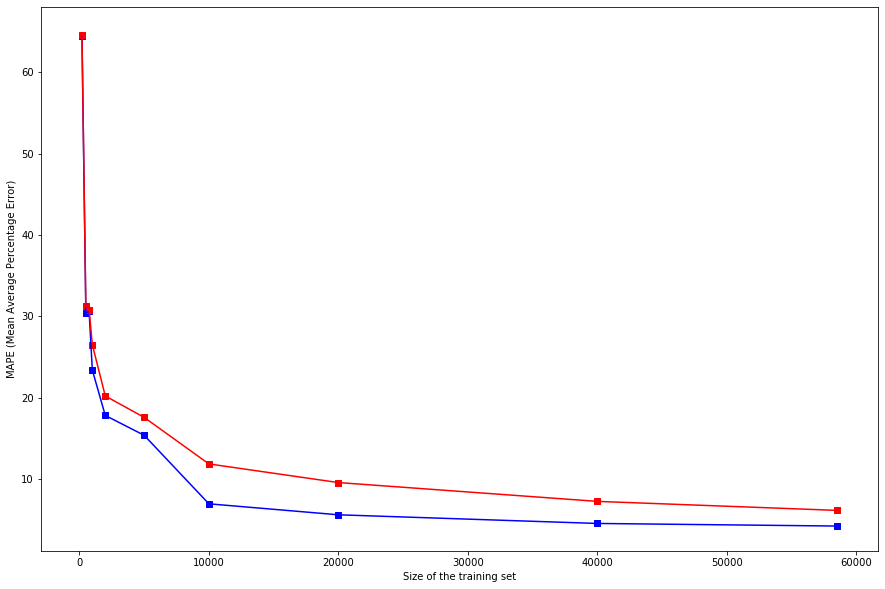

In [15]:
plt.figure(figsize =(15,10))
plt.scatter(df["size"], df["MAPE train"], color ="blue", marker = "s")
plt.plot(df["size"], df["MAPE train"], color ="blue")
plt.scatter(df["size"], df["MAPE test"], color ="red", marker = "s")
plt.plot(df["size"], df["MAPE test"], color ="red")
plt.xlabel("Size of the training set")
plt.ylabel("MAPE (Mean Average Percentage Error)")
plt.savefig("net_mape_training_size.png")
plt.show()